In [ ]:
## Installing the mediapipe library
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 20.1 MB/s eta 0:00:00


In [ ]:
## Importing necessary libraries
import os
import os.path
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from timeit import default_timer as timer
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display
import cv2
import numpy as np
import os
from scipy import stats
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
import pickle

In [ ]:
## defining markdown function
def md(string):   
    display(Markdown(string))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/MyDrive

Data preprocessing and visualization

In [ ]:
# Create a list with the filepaths for training and testing
dir_ = Path('/content/drive/MyDrive/asl_alphabet_train')
file_paths = list(dir_.glob(r'**/*.jpg'))

In [ ]:
def process_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = process_img(file_paths)

print(f'Number of pictures in the dataset: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
df.head(5)

Number of pictures in the dataset: 87000

Number of different labels: 29

Labels: ['W' 'del' 'G' 'X' 'Y' 'space' 'K' 'I' 'H' 'E' 'P' 'J' 'nothing' 'Q' 'S'
 'A' 'C' 'T' 'L' 'M' 'N' 'F' 'B' 'D' 'R' 'O' 'Z' 'V' 'U']


,Filepath,Label
0,../input/american-sign-language-gaurav/asl_alp...,W
1,../input/american-sign-language-gaurav/asl_alp...,del
2,../input/american-sign-language-gaurav/asl_alp...,G
3,../input/american-sign-language-gaurav/asl_alp...,X
4,../input/american-sign-language-gaurav/asl_alp...,Y


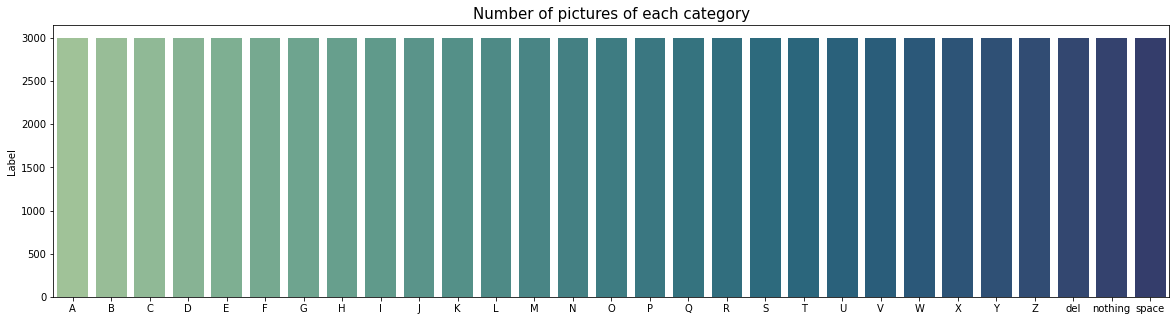

In [ ]:
# Display the number of pictures of each category
counts = df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(counts.index), y = counts, palette = "crest")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
# Displaying the shape of each image
k = plt.imread(df.Filepath[1])
k.shape

(200, 200, 3)

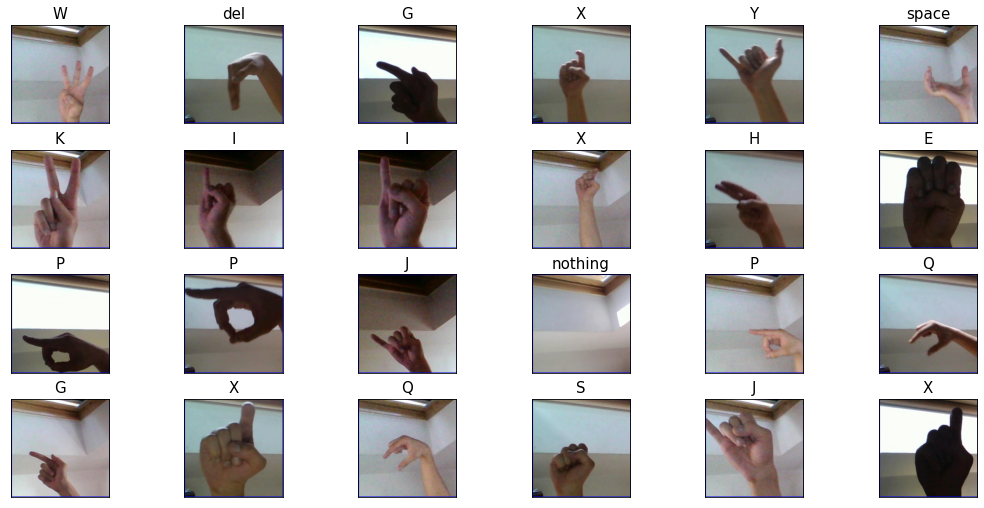

In [ ]:
### plotting few samples
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
# Split into training and test datasets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

In [ ]:
len(train_df)

69600

Load the Images with a generator and Data Augmentation

In [ ]:
# Image Augmentation and Image generator
def create_generator():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,validation_split=0.25
    )


    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
                rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=False,
        fill_mode="nearest",
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest",
    )
    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

Load the generator without data augmentation

In [ ]:
def create_generator1():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=None,validation_split=0.25
    )


    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=None
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
    )
    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
## Doing transfer learning from few models and building the model out of it

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
## Making  custom CNN model out of it
def get_created_model():

  model1 = Sequential()

  model1.add(Conv2D(32, (5, 5), input_shape=(224, 224, 3)))
  model1.add(Activation('relu'))
  model1.add(MaxPooling2D((2, 2)))

  model1.add(Conv2D(64, (3, 3)))
  model1.add(Activation('relu'))
  model1.add(MaxPooling2D((2, 2)))

  model1.add(Conv2D(64, (3, 3)))
  model1.add(Activation('relu'))
  model1.add(MaxPooling2D((2, 2)))

  model1.add(Flatten())

  model1.add(Dense(128, activation='relu'))

  model1.add(Dense(29, activation='softmax'))

  model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

  return model1

In [ ]:
## declaring Pre-trained models for transfer learning
pre_trained_models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

In [ ]:
# Calling train generator for the Image Augmentation and calling different pre-trained models to find out the best model for training.
train_generator,test_generator,train_images,val_images,test_images=create_generator()
print('\n')

# Fit the models
for name, model in pre_trained_models.items():
    
    # Get the model
    mod = get_model(model['model'])
    pre_trained_models[name]['model'] = mod
    
    start = perf_counter()
    
    # Fit the model
    history = mod.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # Sav the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    pre_trained_models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    pre_trained_models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 52200 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.




2022-08-06 07:12:51.869091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 07:12:51.982643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 07:12:51.983721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 07:12:51.989208: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

29097984/29084464 [==============================] - 0s 0us/step


2022-08-06 07:12:58.191084: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-06 07:13:04.669235: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


DenseNet121          trained in 440.7 sec
9420800/9406464 [==============================] - 0s 0us/step
MobileNetV2          trained in 173.04 sec
51888128/51877672 [==============================] - 0s 0us/step
DenseNet169          trained in 202.72 sec
74850304/74836368 [==============================] - 0s 0us/step
DenseNet201          trained in 229.35 sec
16719872/16705208 [==============================] - 0s 0us/step
EfficientNetB0       trained in 181.12 sec
17235968/17225924 [==============================] - 0s 0us/step
MobileNet            trained in 167.25 sec
234708992/234698864 [==============================] - 4s 0us/step
ResNet152            trained in 318.32 sec
94781440/94765736 [==============================] - 1s 0us/step
ResNet50             trained in 187.23 sec
58900480/58889256 [==============================] - 0s 0us/step
VGG16                trained in 191.0 sec
80150528/80134624 [==============================] - 0s 0us/step
VGG19                trained i

In [ ]:
# Create a DataFrame with the results
models_result = []

for name, v in pre_trained_models.items():
    models_result.append([ name, pre_trained_models[name]['val_acc'][-1], 
                          pre_trained_models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,Training time (sec)
0,MobileNet,0.9925,167.25
1,DenseNet201,0.9814,229.35
2,DenseNet169,0.9776,202.72
3,MobileNetV2,0.9741,173.04
4,Xception,0.9656,223.06
5,DenseNet121,0.9605,440.70
6,VGG16,0.9359,191.00
7,VGG19,0.9192,182.70
8,ResNet152,0.5711,318.32
9,ResNet50,0.4889,187.23


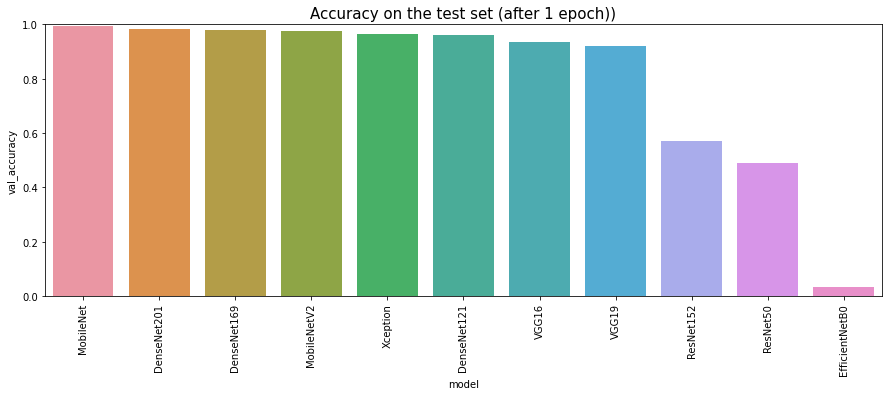

In [ ]:
## Plotting the figure of the accuracy after one epoch for each transfer learning models
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

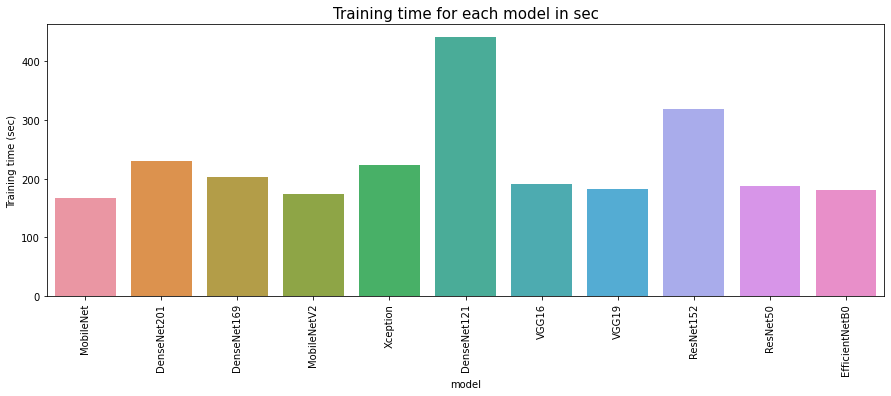

In [ ]:
## Plotting the training time
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

In [ ]:
## fitting the model on the generated images
# Use the whole data which is split into training and test datasets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=0)

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_generator()

train_generator1,test_generator1,train_images1,val_images1,test_images1=create_generator1()

# Get the model with the highest validation score
best_model = df_results.iloc[0]
model = get_model( eval("tf.keras.applications."+ best_model[0]) )
model2 = get_model( eval("tf.keras.applications."+ best_model[0]) )
# Create a new model
model1 = get_created_model()
model3 = get_created_model()
# Train the model
history = model.fit(train_images,validation_data=val_images,epochs=5,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True)])


Found 58725 validated image filenames belonging to 29 classes.
Found 19575 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
Found 58725 validated image filenames belonging to 29 classes.
Found 19575 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
Epoch 1/5
1836/1836 [==============================] - 257s 139ms/step - loss: 0.1974 - accuracy: 0.9472 - val_loss: 0.0907 - val_accuracy: 0.9707
Epoch 2/5
1836/1836 [==============================] - 206s 112ms/step - loss: 0.0315 - accuracy: 0.9896 - val_loss: 0.0431 - val_accuracy: 0.9856
Epoch 3/5
1836/1836 [==============================] - 190s 103ms/step - loss: 0.0243 - accuracy: 0.9922 - val_loss: 0.0458 - val_accuracy: 0.9846


In [ ]:
history1 = model2.fit(train_images1,validation_data=val_images1,epochs=5,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True)])

Epoch 1/5
1836/1836 [==============================] - 180s 97ms/step - loss: 0.8575 - accuracy: 0.7422 - val_loss: 0.4083 - val_accuracy: 0.8676
Epoch 2/5
1836/1836 [==============================] - 181s 99ms/step - loss: 0.3305 - accuracy: 0.8905 - val_loss: 0.2897 - val_accuracy: 0.9020
Epoch 3/5
1836/1836 [==============================] - 176s 96ms/step - loss: 0.2380 - accuracy: 0.9188 - val_loss: 0.2018 - val_accuracy: 0.9324
Epoch 4/5
1836/1836 [==============================] - 179s 97ms/step - loss: 0.1995 - accuracy: 0.9313 - val_loss: 0.2738 - val_accuracy: 0.9078


In [ ]:
## Custom CNN model fit
history2 = model1.fit(train_images,validation_data=val_images,epochs=5,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True)])

Epoch 1/5
1836/1836 [==============================] - 193s 104ms/step - loss: 0.6186 - accuracy: 0.8093 - val_loss: 0.1269 - val_accuracy: 0.9580
Epoch 2/5
1836/1836 [==============================] - 190s 103ms/step - loss: 0.0902 - accuracy: 0.9704 - val_loss: 0.0784 - val_accuracy: 0.9769
Epoch 3/5
1836/1836 [==============================] - 189s 103ms/step - loss: 0.0526 - accuracy: 0.9835 - val_loss: 0.1285 - val_accuracy: 0.9634


In [ ]:
history3 = model3.fit(train_images1,validation_data=val_images1,epochs=5,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True)])

Epoch 1/5
1836/1836 [==============================] - 179s 97ms/step - loss: 1.6790 - accuracy: 0.6725 - val_loss: 0.6038 - val_accuracy: 0.8003
Epoch 2/5
1836/1836 [==============================] - 179s 97ms/step - loss: 0.3110 - accuracy: 0.8950 - val_loss: 0.2469 - val_accuracy: 0.9138
Epoch 3/5
1836/1836 [==============================] - 182s 99ms/step - loss: 0.1742 - accuracy: 0.9418 - val_loss: 0.2011 - val_accuracy: 0.9397
Epoch 4/5
1836/1836 [==============================] - 176s 96ms/step - loss: 0.1222 - accuracy: 0.9621 - val_loss: 0.1853 - val_accuracy: 0.9472
Epoch 5/5
1836/1836 [==============================] - 178s 97ms/step - loss: 0.1038 - accuracy: 0.9683 - val_loss: 0.1758 - val_accuracy: 0.9497


In [ ]:
## Defining afunction to print plot for depecting val accuracy and accuracy, loss and val-loss
def le_curve(history,c):
    pd.DataFrame(history.history).plot(figsize=(8, 5)) 
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.title(c, fontsize = 15)
    plt.show()

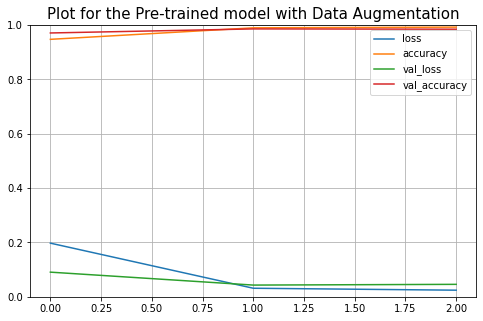

In [ ]:
le_curve(history, "Plot for the Pre-trained model with Data Augmentation")

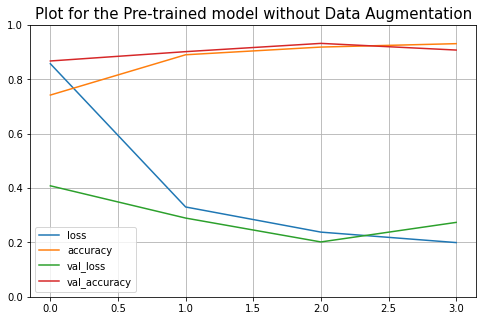

In [ ]:
le_curve(history1, "Plot for the Pre-trained model without Data Augmentation")

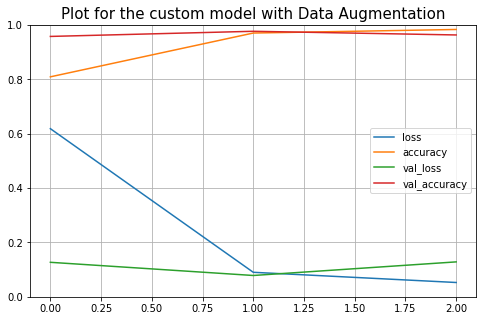

In [ ]:
le_curve(history2, "Plot for the custom model with Data Augmentation")

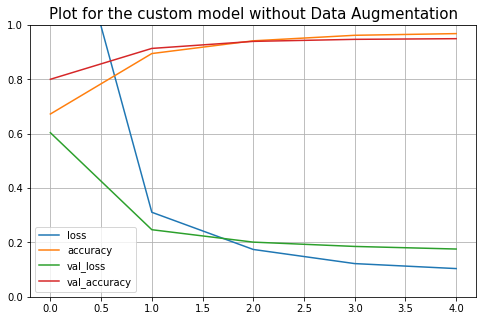

In [ ]:
le_curve(history3,'Plot for the custom model without Data Augmentation')

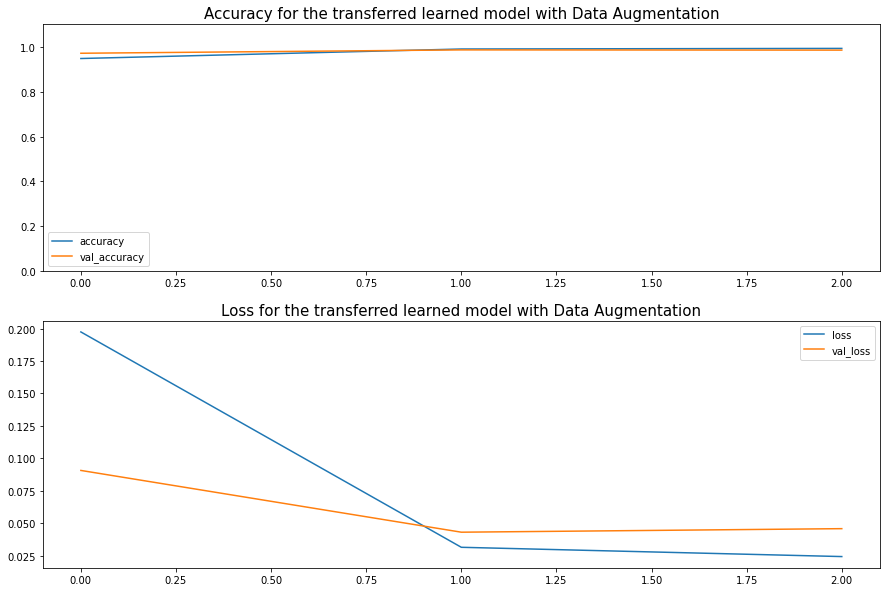

In [ ]:
fig1, axes1 = plt.subplots(2, 1, figsize=(15, 10))
ax1 = axes1.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax1[0])
ax1[0].set_title("Accuracy for the transferred learned model with Data Augmentation", fontsize = 15)
ax1[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax1[1])
ax1[1].set_title("Loss for the transferred learned model with Data Augmentation", fontsize = 15)
plt.show()

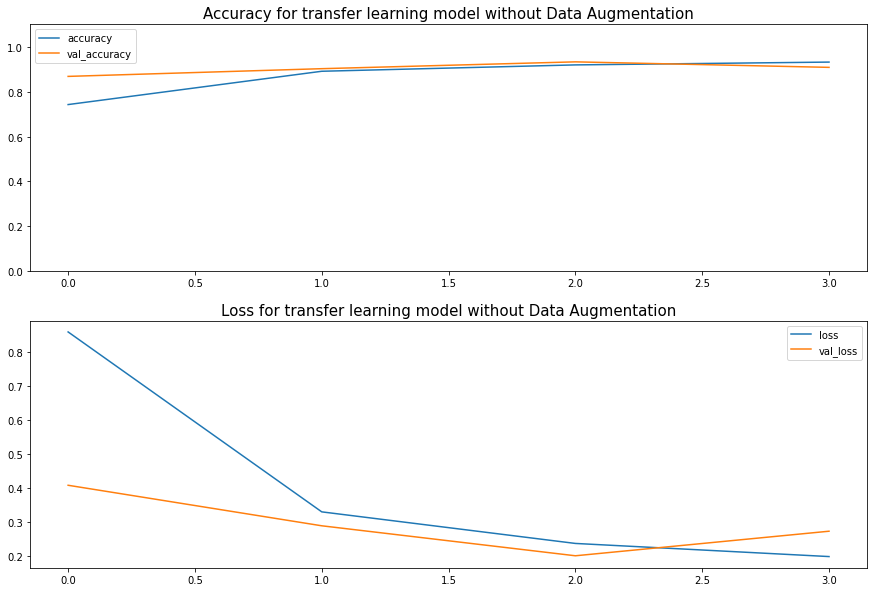

In [ ]:
fig2, axes2 = plt.subplots(2, 1, figsize=(15, 10))
ax2 = axes2.flat

pd.DataFrame(history1.history)[['accuracy','val_accuracy']].plot(ax=ax2[0])
ax2[0].set_title("Accuracy for transfer learning model without Data Augmentation", fontsize = 15)
ax2[0].set_ylim(0,1.1)

pd.DataFrame(history1.history)[['loss','val_loss']].plot(ax=ax2[1])
ax2[1].set_title("Loss for transfer learning model without Data Augmentation", fontsize = 15)
plt.show()

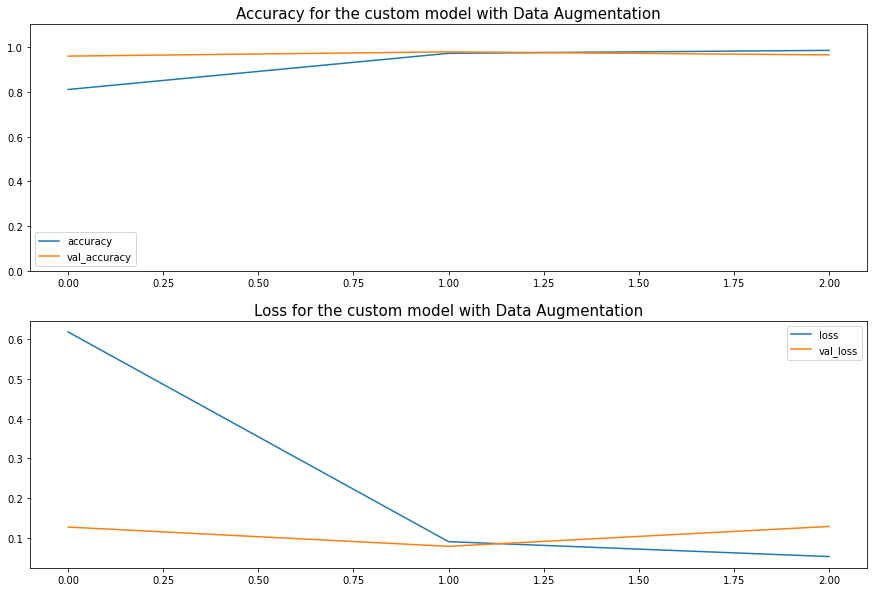

In [ ]:
fig3, axes3 = plt.subplots(2, 1, figsize=(15, 10))
ax3 = axes3.flat

pd.DataFrame(history2.history)[['accuracy','val_accuracy']].plot(ax=ax3[0])
ax3[0].set_title("Accuracy for the custom model with Data Augmentation", fontsize = 15)
ax3[0].set_ylim(0,1.1)

pd.DataFrame(history2.history)[['loss','val_loss']].plot(ax=ax3[1])
ax3[1].set_title("Loss for the custom model with Data Augmentation", fontsize = 15)
plt.show()

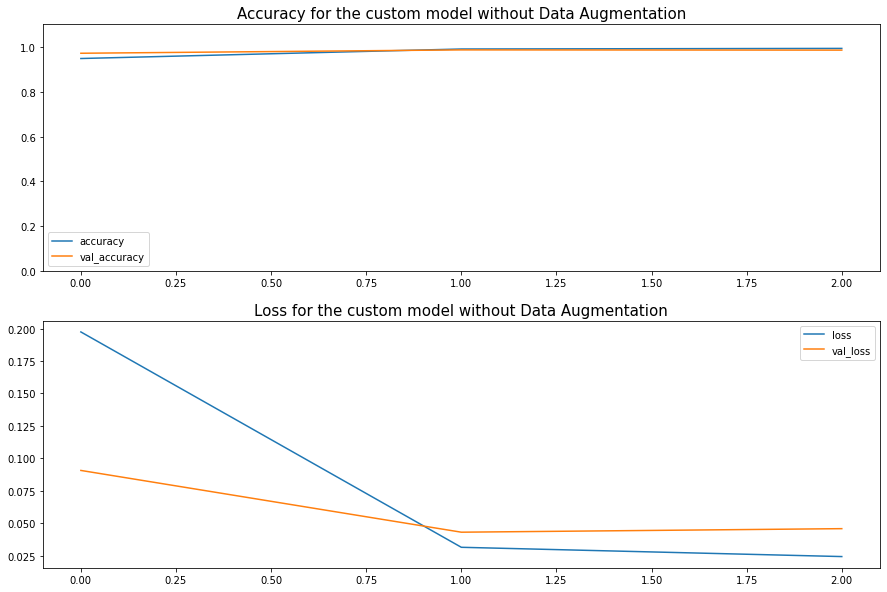

In [ ]:
fig4, axes4 = plt.subplots(2, 1, figsize=(15, 10))
ax4 = axes4.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax4[0])
ax4[0].set_title("Accuracy for the custom model without Data Augmentation", fontsize = 15)
ax4[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax4[1])
ax4[1].set_title("Loss for the custom model without Data Augmentation", fontsize = 15)
plt.show()

Train the architecture with the best result

## Model with data augmentation with 98.48% accuracy on the test set

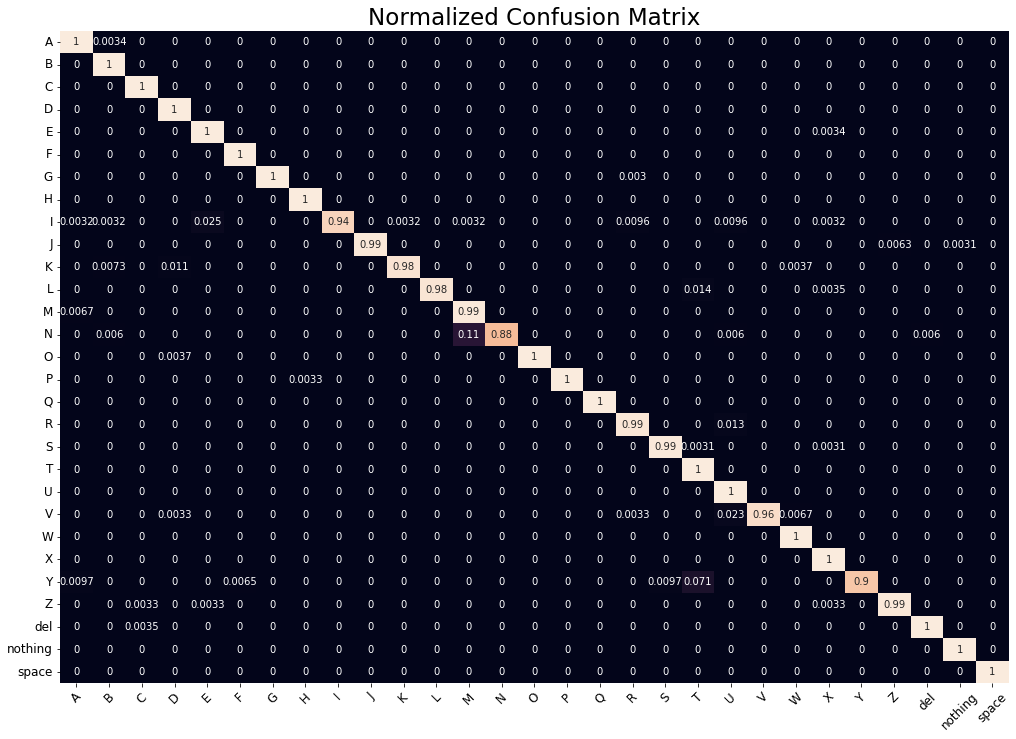

In [ ]:
## finding the accuracy on the test set and printing the conf. matrix for the best model out of pre-trained models
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Get the accuracy on the test set
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)

# Display the results
md(f'## Model with data augmentation with {acc*100:.2f}% accuracy on the test set')

# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (17,12))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.show()

## Model without data augmentation with 92.85% accuracy on the test set

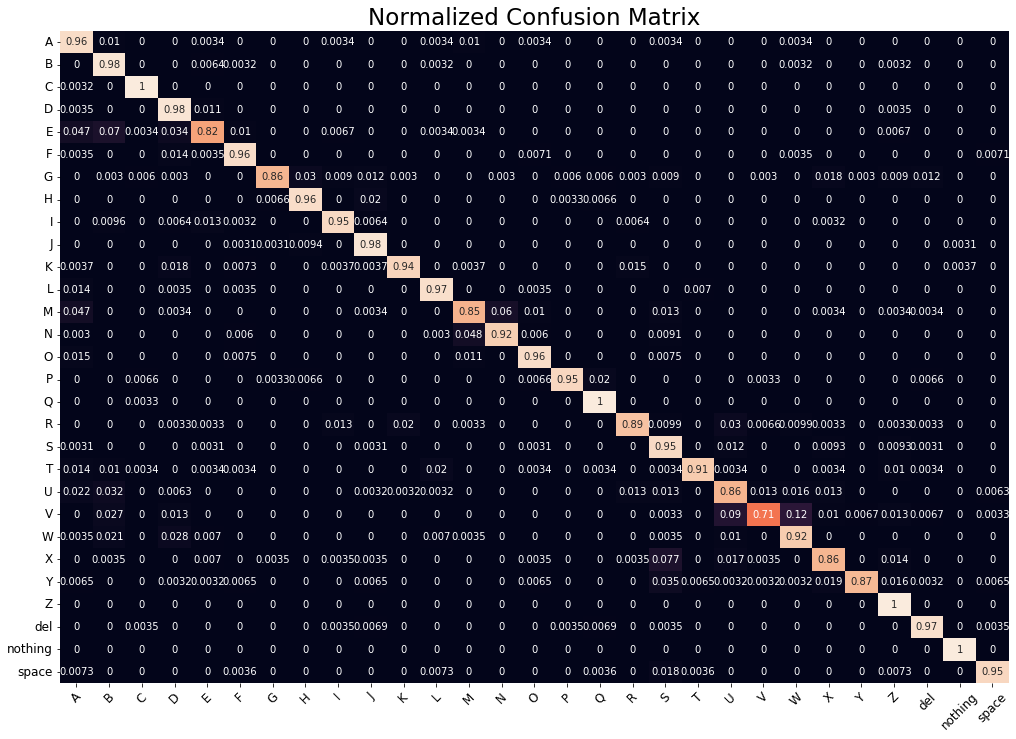

In [ ]:
## finding the accuracy on the test set and printing the conf. matrix for the best model out of pre-trained models
# Predict the label of the test_images
pred2 = model2.predict(test_images1)
pred2 = np.argmax(pred2,axis=1)

# Map the label
labels2 = (train_images1.class_indices)
labels2 = dict((v,k) for k,v in labels2.items())
pred2 = [labels2[k] for k in pred2]

# Get the accuracy on the test set
y_test = list(test_df.Label)
acc2 = accuracy_score(y_test,pred2)

# Display the results
md(f'## Model without data augmentation with {acc2*100:.2f}% accuracy on the test set')

# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, pred2, normalize='true')
plt.figure(figsize = (17,12))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0  

In [ ]:
train_generator,test_generator,train_images,val_images,test_images=create_generator()

Found 58725 validated image filenames belonging to 29 classes.
Found 19575 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


In [ ]:
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels_detection = dict((k,v) for k,v in labels.items())

In [ ]:
labels_detection

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z',
 26: 'del',
 27: 'nothing',
 28: 'space'}

In [ ]:
with open('labels_detection.pickle', 'wb') as f:
    pickle.dump(labels_detection, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('labels_detection.pickle', 'rb') as f:
    labels1 = pickle.load(f)

In [ ]:
labels1[0]

'A'

## Designed Model with data augmentation with 97.72% accuracy on the test set

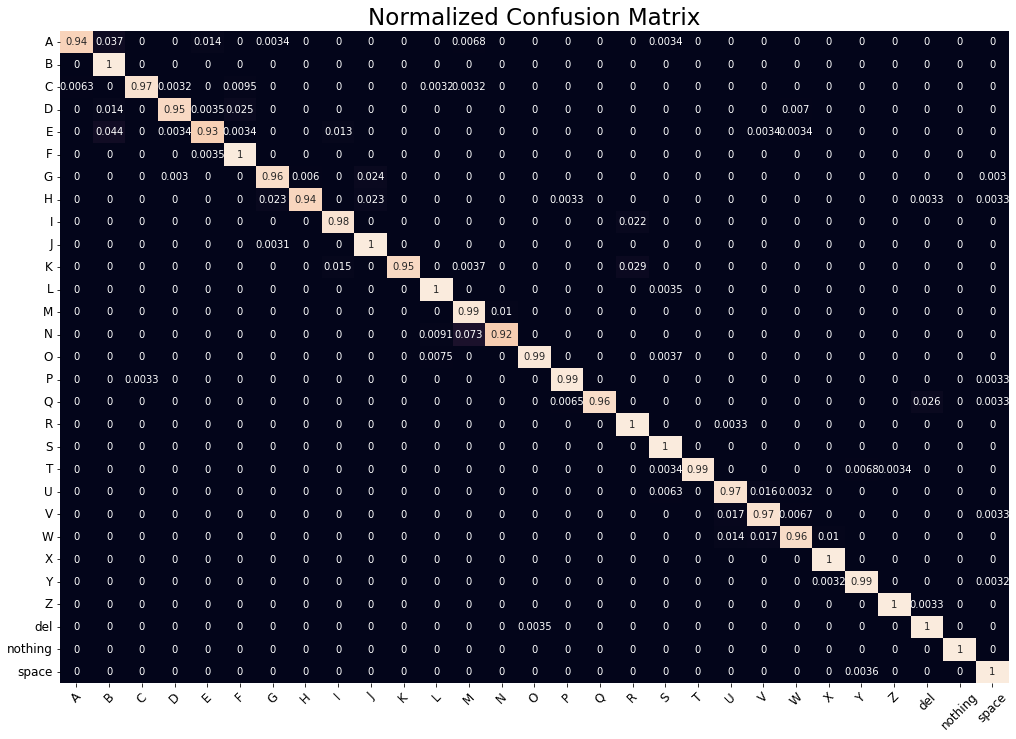

In [ ]:
## finding the accuracy on the test set and printing the conf. matrix for the CNN model
# Predict the label of the test_images
pred1 = model1.predict(test_images)
pred1 = np.argmax(pred1,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred1]

# Get the accuracy on the test set
y_test = list(test_df.Label)
acc1 = accuracy_score(y_test,pred1)

# Display the results
md(f'## Designed Model with data augmentation with {acc1*100:.2f}% accuracy on the test set')

# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, pred1, normalize='true')
plt.figure(figsize = (17,12))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.show()

## Designed Model without data augmentation with 94.74% accuracy on the test set

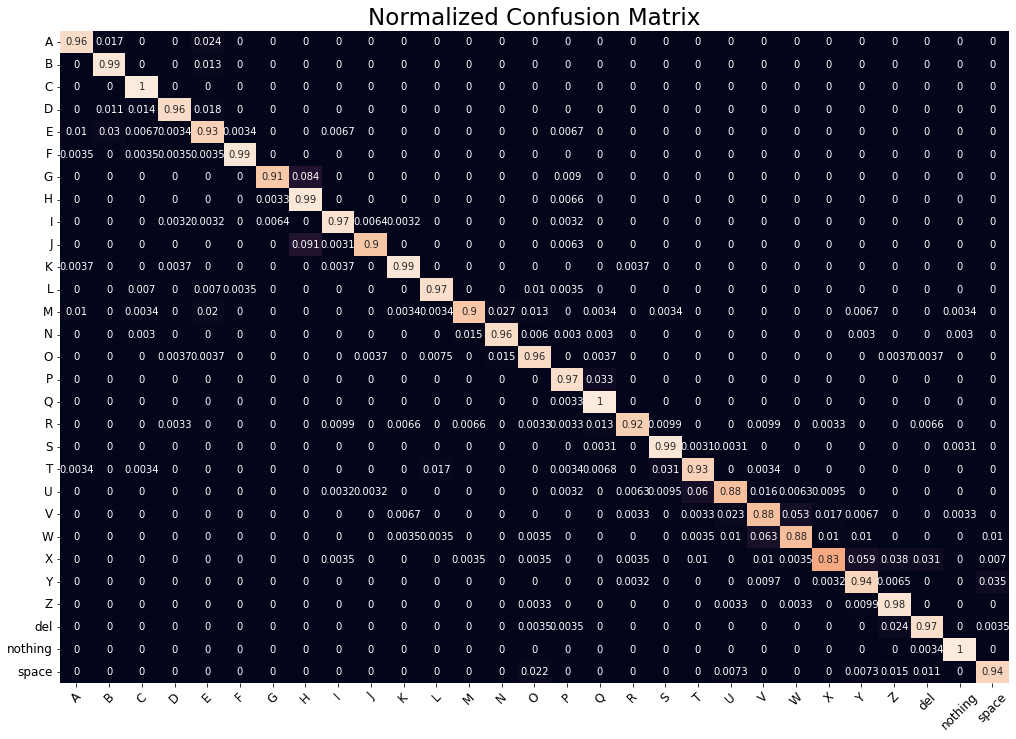

In [ ]:
## finding the accuracy on the test set and printing the conf. matrix for the CNN model
# Predict the label of the test_images
pred3 = model3.predict(test_images1)
pred3 = np.argmax(pred3,axis=1)

# Map the label
labels3 = (train_images1.class_indices)
labels3 = dict((v,k) for k,v in labels3.items())
pred3 = [labels3[k] for k in pred3]

# Get the accuracy on the test set
y_test = list(test_df.Label)
acc3 = accuracy_score(y_test,pred3)

# Display the results
md(f'## Designed Model without data augmentation with {acc3*100:.2f}% accuracy on the test set')

# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, pred3, normalize='true')
plt.figure(figsize = (17,12))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.show()

Examples of Prediction

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
activation (Activation)      (None, 220, 220, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 108, 108, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 64)        3

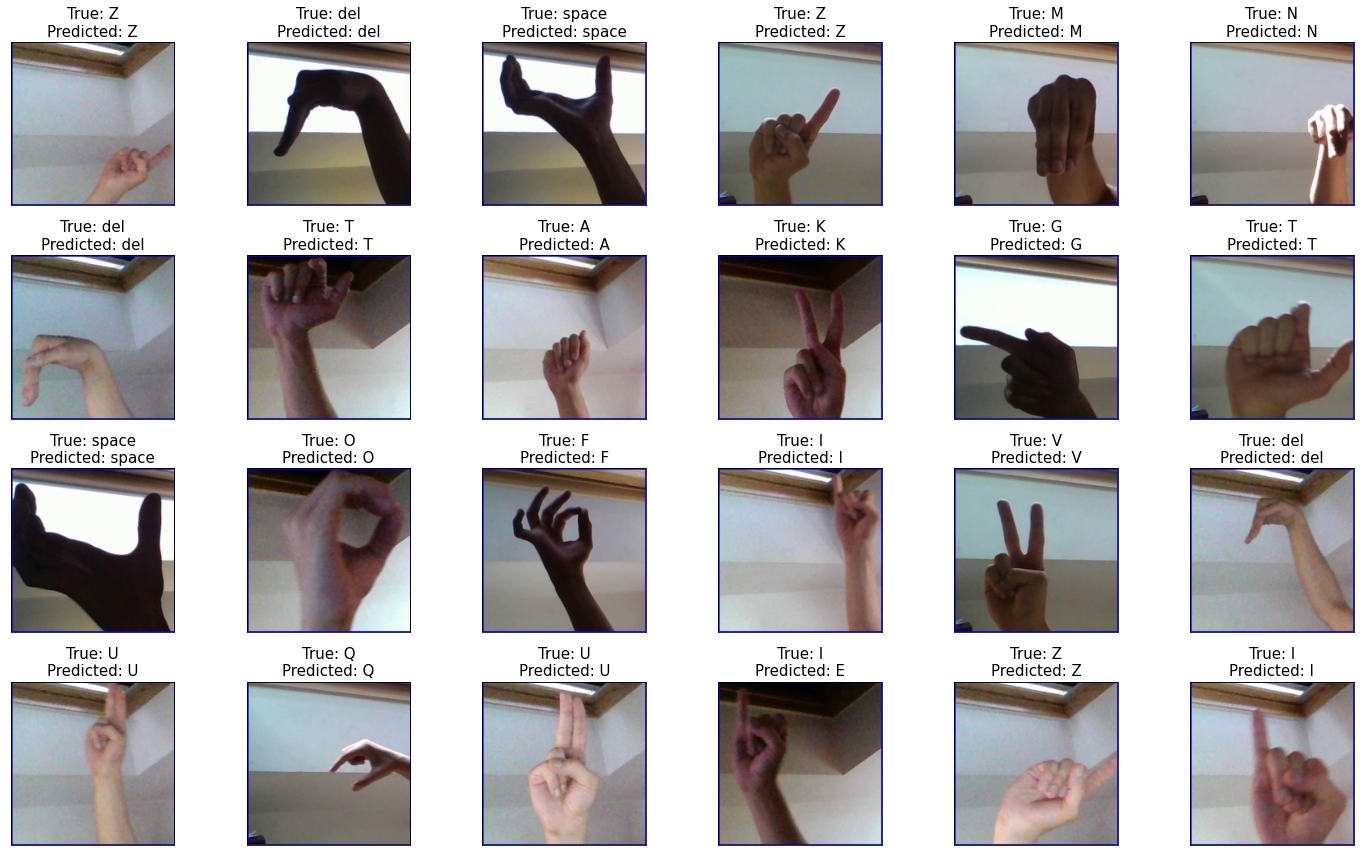

In [ ]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

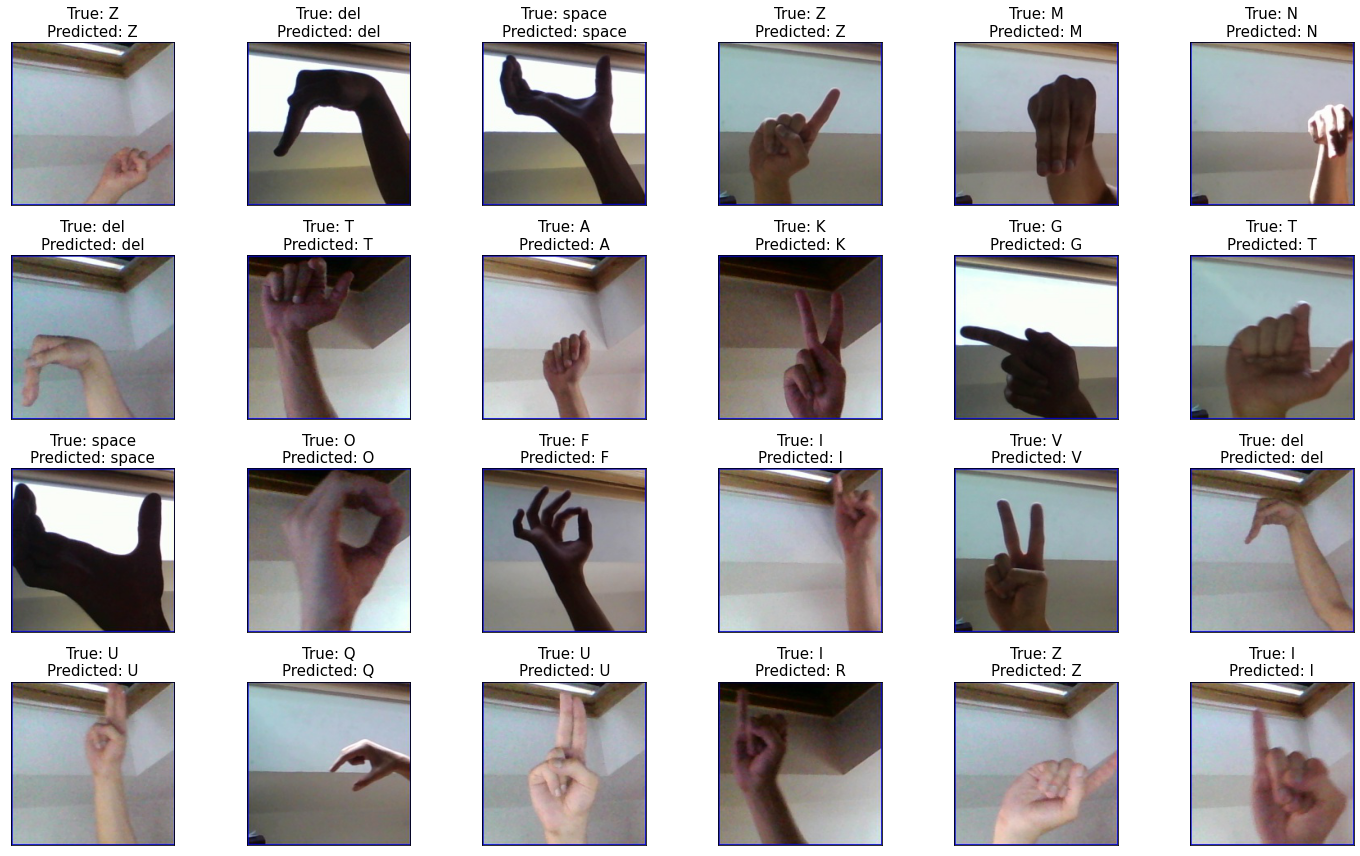

In [ ]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred1[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

In [ ]:
## saving the model to the json file
model1_json = model1.to_json()

with open("/content/drive/MyDrive/custom_cnn_model.json", "w") as json_file:
    json_file.write(model1_json)

In [ ]:
## saving the transfer learned model to the json file
model_json = model.to_json()

with open("/content/drive/MyDrive/transfer_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
## saving the weights for the model
model1.save_weights("/content/drive/MyDrive/custom_cnn_model.h5")

In [ ]:
## saving the weights for transfer learned model
model1.save_weights("/content/drive/MyDrive/transfer_model.h5")

In [ ]:
# load json and create model
json_file = open('/content/drive/MyDrive/custom_cnn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/custom_cnn_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
score = loaded_model.evaluate(test_images)

272/272 [==============================] - 21s 76ms/step - loss: 0.0802 - accuracy: 0.9772
